In [1]:
library(plotly)
library(knitr)
source("../src/cov_sampler2.R")
load("../src/samples_5apr.RData")
data=data.I


Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




Download data


Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



## country labels

In [2]:
order_AZ=order(data.frame(country[,1]))

In [3]:
nrow(data)

[1] 153

## current state

In [4]:
nt=ncol(data); state=data.frame(confirmed=data.C[,nt],recovered=data.R[,nt],deaths=data.D[,nt]);rownames(state)=labels
md_text=kable(state[order_AZ,])
write(md_text,"../current_state.md")

# Figures of the parameters

In [5]:

samples=sam_globX


# Figure 1

png("../Figures/Figure_1.png",width=400,height=400)
plot(cov.sim(c(.14,.01,.01,10,2),100,.1)[[1]],type='l',lwd=2,xlab="time (days)", ylab="Infected cases")
grid()
dev.off()

# Figure stat

png("../Figures/Figure_stat_1.png",width=600,height=400)
country_index=which(country[,1]=="Italy")
barplot(rbind((data.I[country_index,]),
	      (data.R[country_index,]), 
	      (data.D[country_index,])),
	col=c("red","green","purple" ),las=2,names.arg=names(rawdata_conf))
legend("topleft",legend=c("infected","recovered","deaths"),fill=c("red","green","purple" ))

dev.off()

png("../Figures/Figure_henan.png",width=600,height=400)
country_index=which(province[,1]=="Henan")
barplot(rbind((data.I[country_index,]),
	      (data.R[country_index,]), 
	      (data.D[country_index,])),
	col=c("red","green","purple" ),las=2,names.arg=names(rawdata_conf))
legend("topleft",legend=c("infected","recovered","deaths"),fill=c("red","green","purple" ))

dev.off()

png("../Figures/Figure_hubei.png",width=600,height=400)
country_index=which(province[,1]=="Hubei")
barplot(rbind((data.I[country_index,]),
	      (data.R[country_index,]), 
	      (data.D[country_index,])),
	col=c("red","green","purple" ),las=2,names.arg=names(rawdata_conf))
legend("topleft",legend=c("infected","recovered","deaths"),fill=c("red","green","purple" ))

dev.off()



# Figure param lambda

par_comb=vector("list",5)

par_comb[[1]]=par_comb[[1]]=unlist(lapply(samples,"[[",'lambda'))
for(i in 2:5){
    par_comb[[i]]=t(do.call(cbind,lapply(samples,function(x) x$param[,i-1])))
                                         colnames(par_comb[[i]])=labels
}

png("../Figures/Figure_stat_lambda.png",width=600,height=400)
hist(unlist(lapply(samples,function(x) x$lambda)),
     main="",
     xlab="worldwide daily infection rate",
     ylab="frequency",freq=0)
dev.off()


for(i in 2:5){
	png(paste("../Figures/Figure_stat_",i,".png",sep=""),width=700,height=5000)
	means=colMeans(par_comb[[i]])
	ord=order(means,decreasing=T)
	par(mar=c(6,15,3,3))
	boxplot(par_comb[[i]][,ord], horizontal=T,las=2,outline=F,log='x')
	dev.off()
}

X11cairo 
       2

X11cairo 
       2

X11cairo 
       2

X11cairo 
       2

X11cairo 
       2

In [6]:
png(paste("../Figures/Figure_stat_UK.png",sep=""),width=700,height=500)
ind=which(country[,1]=="United Kingdom")[3]; cov.plotFromGlobal(ind,sam_globX,90,100,ymax=3000)
legend("topleft",legend=c("data","posterior sample"),lty=c(NA,2),pch=c(21,NA),col=c("black","red"))
dev.off()

png(paste("../Figures/Figure_stat_Italy.png",sep=""),width=700,height=500)
ind=which(country[,1]=="Italy")[1]; cov.plotFromGlobal(ind,sam_globX,90,100,ymax=300000)
legend("topleft",legend=c("data","posterior sample"),lty=c(NA,2),pch=c(21,NA),col=c("black","red"))
dev.off()

X11cairo 
       2

X11cairo 
       2

# Generate plotly chart

In [7]:
cov.getAllAreas <- function(samples,tf,n){
        Nsam=length(samples)
        traces=array(NA,dim=c(nrow(data),tf,n))
        counter=1
        for(i in (Nsam-n+1):Nsam){
            s=samples[[i]]
            p=data.frame(lambda=s$lam,
                         h=s$param[,1],
                         x0=s$param[,2],
                         k=s$param[,3],
                         g=s$param[,4]
                     )
              
                res=cov.SIM(p,tf)
                pp=1/(1+(p[,'k']/res$Rx)^p[,'g'])
                traces[,,counter]=res$Rx*pp
                counter=counter+1
        }
        return(list(data=data,
                    q1=apply(traces,c(1,2),quantile,prob=0.05),
                    q2=apply(traces,c(1,2),quantile,prob=0.5),
                    q3=apply(traces,c(1,2),quantile,prob=0.95),
                    peaks=apply(
                              apply(traces,c(1,3),max),1,quantile,probs=c(0.05,.5,0.95) 
                           ),
                    times=apply(
                              apply(traces,c(1,3),function(x) sum(x>1)),1,quantile,probs=c(0.05,.5,0.95)) 
                   ))
                    
}



In [8]:
## Collecting a posterior samples. This can take a few minutes
AreaList=cov.getAllAreas(sam_globX,ncol(data)+300,1000)

In [9]:
save(AreaList,file="../src/AreaList_HM-0504.RData")

In [10]:
#load(file="../src/AreaList.RData")

In [10]:
# function to set the visible

setvisible <- function(i,n){
        bv=rep(FALSE,n)
        bv[i]=TRUE

        return(rep(bv,each=4))
}

buttons = vector("list",nrow(data))
for(j in 1:nrow(data)){
    i=order_AZ[j]
        buttons[[j]]=list(method = "restyle",
                          args = list("visible",setvisible(i,nrow(data))),
                          label = labels[i])
}


tf=ncol(data)+100
fig<-plot_ly()

time_axis=format(as.Date(seq(1,tf,7),origin="21 Jan 2020",format="%d %b %Y"),"%d %b %Y")

for(i in 1:nrow(data)){
    
        fig <- fig %>% add_trace(x=1:ncol(data),y=data[i,],
                                 name="data",
                                 type="scatter", mode="markers",visible=(i==1))
         fig <- fig %>% add_lines(x=1:tf,y=AreaList$q2[i,],  
                                  name="median",
                                  line = list(color = 'rgba(0,100,80,1)'),
                                  visible=(i==1)) 
         fig <- fig %>% add_lines(x=1:tf,y=AreaList$q1[i,],  
                                  name="5th percentile",
                                  line = list(color = 'rgba(0,100,80,1)'),
                                  visible=(i==1)) 
         fig <- fig %>% add_lines(x=1:tf,y=AreaList$q3[i,],
                                  name="95th percentile",
                                  fill = 'tonexty', fillcolor='rgba(0,100,80,0.2)',
                                  line = list(color = 'rgba(0,100,80,1)'),
                                  visible=(i==1))
         fig <- fig %>% layout(xaxis=list(ticktext=time_axis,tickvals=seq(1,tf,7)))
}

fig <- fig %>% layout(
    updatemenus = list(
      list(
          
          showactive=TRUE,
          x=0,
          xanchor="left",
          y=1.4,
          yanchor="top",
          buttons=buttons
        )
    ))

fig



ERROR while rich displaying an object: Error: Tibble columns must have consistent lengths, only values of length one are recycled:
* Length 174: Column `x`
* Length 374: Column `y`

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, er

ERROR while rich displaying an object: Error: Tibble columns must have consistent lengths, only values of length one are recycled:
* Length 174: Column `x`
* Length 374: Column `y`

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, er

HTML widgets cannot be represented in plain text (need html)

In [ ]:
htmlwidgets::saveWidget(fig, "plotly_chart.html")

## Analysis of peak/duration of the infection

In [14]:
png("../Figures/Figure_ranking_peak.png",width=600,height=400)
ord=order(AreaList$peaks[2,])
par(mar=c(5,15,1,1))
barplot(AreaList$peaks[2,tail(ord,10)],names.arg = labels[tail(ord,10)],
        main="infection peak", xlab="cases",las=1,horiz = T)
dev.off()

X11cairo 
       2

In [15]:
png("../Figures/Figure_ranking_duration.png",width=600,height=400)
ord=order(AreaList$times[2,])
par(mar=c(5,15,1,1))
barplot(AreaList$times[2,tail(ord,10)],
        names.arg = labels[tail(ord,10)],
        main="Duration",xlab="days",
        las=1,horiz=T)
dev.off()

X11cairo 
       2

In [16]:
png("../Figures/Figure_ranking_ratio.png",width=600,height=400)
rat=(AreaList$peaks[2,]/AreaList$times[2,])
s=!is.infinite(rat)
rat=rat[s]
labels2=labels[s]

ord=order(rat)

par(mar=c(5,15,1,1))
barplot(rat[tail(ord,10)],names.arg = labels2[tail(ord,10)],
        main="peak/duration ratio", log='x',horiz = T,las=1)
dev.off()

X11cairo 
       2

## Analysis of predictive power

In [14]:
load("../src/samples_14mar-3.RData")

In [16]:
cov.getDiff <- function(samples,n){
        tf=ncol(data)
        Nsam=length(samples)
        traces=array(NA,dim=c(nrow(data),tf,n))
        counter=1
        for(i in (Nsam-n+1):Nsam){
            s=samples[[i]]
            p=data.frame(lambda=s$lam,
                         h=s$param[,1],
                         x0=s$param[,2],
                         k=s$param[,3],
                         g=s$param[,4]
                     )
              
                res=cov.SIM(p,tf)
                pp=1/(1+(p[,'k']/res$Rx)^p[,'g'])
                traces[,,counter]=(res$Rx*pp)
                counter=counter+1
        }
        return(traces)
                    
}


In [18]:
t_predict=cov.getDiff(sam_glob_pred,2000)

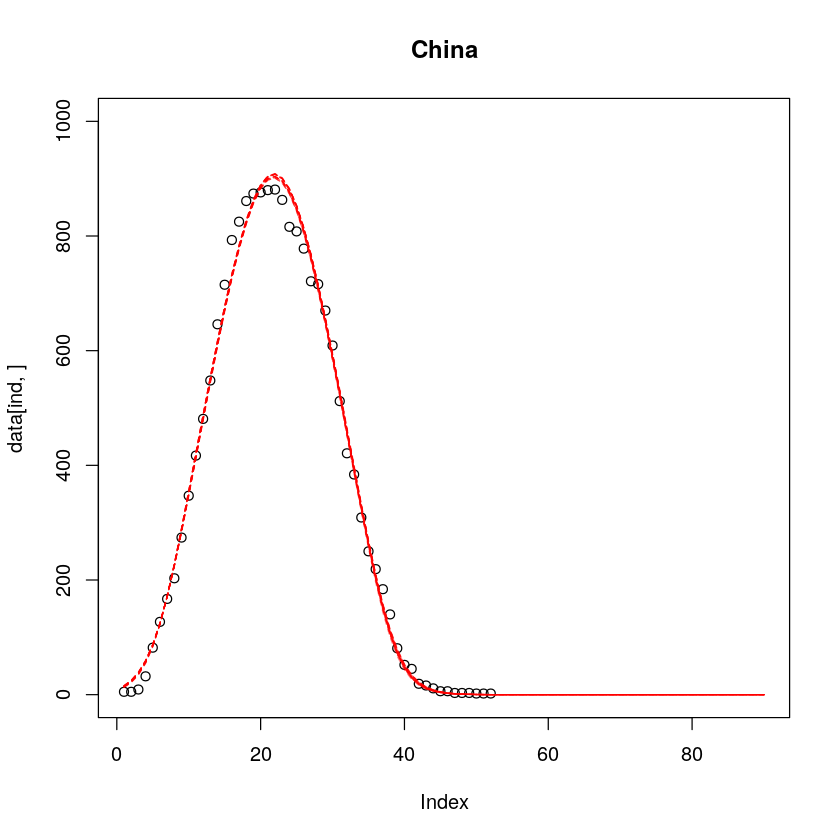

In [27]:
ind=which(province[,1]=="Henan"); cov.plotFromGlobal(ind,sam_glob_pred,90,20,1000)

In [23]:
ncol(data)

[1] 52

In [25]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
means=apply(t_predict,c(1,2),mean)
sds=apply(t_predict,c(1,2),sd)
pp=(data[,49:52]-means[,49:52])/sqrt(sds[,49:52]^2+means[,49:52])
rownames(pp)=labels
ord=order(pp[,1])
pp_ord=cbind(pp[ord,],total=data[ord,49])
pp_ord[pp_ord[,'total']>10,]



,3/10/20,3/11/20,3/12/20,3/13/20,total
"China,Shandong",-5.730003587,-5.5149340,-5.7149471,-5.8057502,33
"Korea, South",-1.205797827,1.0222872,2.7976881,4.2516623,7212
Belgium,-0.897850839,-1.1000948,-2.0511204,2.8348365,266
Iran,-0.849703228,1.2377316,4.4780973,7.4603215,5020
Netherlands,-0.200137506,1.5297011,0.3659102,3.1378167,378
Qatar,-0.062981341,9.2025736,5.3143915,4.1942363,24
Switzerland,0.003561676,1.6280929,0.5702989,3.6977960,485
Estonia,0.188061493,0.5555559,0.3548605,3.4450822,12
Peru,0.206135219,0.5254474,1.5980121,3.6550751,11
"US,New York",0.208412047,0.6125490,1.5220742,2.0623559,173
